In [ ]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight

pd.set_option('display.max_columns', None)

In [214]:
df = pd.read_csv("logs_api_test.tsv", sep="\t")

data = pd.DataFrame()

/tmp/ipykernel_75365/414386446.py:1: DtypeWarning: Columns (92,96,97,101,112,116,127,131,137,138,139,141,142,143,153,154,155,165,166,167,172,173,176,177,188,189,198,199,276,289,290,291,292,294,297,298,299) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("logs_api_test.tsv", sep="\t")


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13604 entries, 0 to 13603
Columns: 403 entries, ym:s:automaticAdvEngine to ym:s:promotionType
dtypes: float64(68), int64(62), object(272), uint64(1)
memory usage: 41.8+ MB


In [216]:
df.head()

,ym:s:automaticAdvEngine,ym:s:automaticTrafficSource,ym:s:bounce,ym:s:counterUserIDHash,ym:s:cross_device_firstAdvEngine,ym:s:cross_device_firstTrafficSource,ym:s:cross_device_last_significantAdvEngine,ym:s:cross_device_last_significantTrafficSource,ym:s:cross_device_last_yandex_direct_clickAdvEngine,ym:s:cross_device_last_yandex_direct_clickTrafficSource,ym:s:cross_device_lastAdvEngine,ym:s:cross_device_lastTrafficSource,ym:s:date,ym:s:dateTime,ym:s:dateTimeUTC,ym:s:endURL,ym:s:firstAdvEngine,ym:s:firstTrafficSource,ym:s:goalsCurrency,ym:s:goalsDateTime,ym:s:goalsID,ym:s:goalsOrder,ym:s:goalsPrice,ym:s:goalsSerialNumber,ym:s:ipAddress,ym:s:isNewUser,ym:s:last_yandex_direct_clickAdvEngine,ym:s:last_yandex_direct_clickTrafficSource,ym:s:lastAdvEngine,ym:s:lastsignAdvEngine,ym:s:lastsignTrafficSource,ym:s:lastTrafficSource,ym:s:networkType,ym:s:pageViews,ym:s:regionCity,ym:s:regionCityID,ym:s:regionCountry,ym:s:regionCountryID,ym:s:startURL,ym:s:visitDuration,ym:s:visitID,ym:s:watchIDs,ym:s:automaticReferalSource,ym:s:automaticSearchEngine,ym:s:automaticSearchEngineRoot,ym:s:automaticSocialNetwork,ym:s:automaticSocialNetworkProfile,ym:s:cross_device_firstReferalSource,ym:s:cross_device_firstSearchEngine,ym:s:cross_device_firstSearchEngineRoot,ym:s:cross_device_firstSocialNetwork,ym:s:cross_device_firstSocialNetworkProfile,ym:s:cross_device_last_significantReferalSource,ym:s:cross_device_last_significantSearchEngine,ym:s:cross_device_last_significantSearchEngineRoot,ym:s:cross_device_last_significantSocialNetwork,ym:s:cross_device_last_significantSocialNetworkProfile,ym:s:cross_device_last_yandex_direct_clickReferalSource,ym:s:cross_device_last_yandex_direct_clickSearchEngine,ym:s:cross_device_last_yandex_direct_clickSearchEngineRoot,ym:s:cross_device_last_yandex_direct_clickSocialNetwork,ym:s:cross_device_last_yandex_direct_clickSocialNetworkProfile,ym:s:cross_device_lastReferalSource,ym:s:cross_device_lastSearchEngine,ym:s:cross_device_lastSearchEngineRoot,ym:s:cross_device_lastSocialNetwork,ym:s:cross_device_lastSocialNetworkProfile,ym:s:firstReferalSource,ym:s:firstSearchEngine,ym:s:firstSearchEngineRoot,ym:s:firstSocialNetwork,ym:s:firstSocialNetworkProfile,ym:s:last_yandex_direct_clickReferalSource,ym:s:last_yandex_direct_clickSearchEngine,ym:s:last_yandex_direct_clickSearchEngineRoot,ym:s:last_yandex_direct_clickSocialNetwork,ym:s:last_yandex_direct_clickSocialNetworkProfile,ym:s:lastReferalSource,ym:s:lastSearchEngine,ym:s:lastSearchEngineRoot,ym:s:lastsignReferalSource,ym:s:lastsignSearchEngine,ym:s:lastsignSearchEngineRoot,ym:s:lastsignSocialNetwork,ym:s:lastsignSocialNetworkProfile,ym:s:lastSocialNetwork,ym:s:lastSocialNetworkProfile,ym:s:automaticClickBannerGroupName,ym:s:automaticDirectBannerGroup,ym:s:automaticDirectClickBanner,ym:s:automaticDirectClickOrder,ym:s:automaticDirectClickOrderName,ym:s:cross_device_firstClickBannerGroupName,ym:s:cross_device_firstDirectBannerGroup,ym:s:cross_device_firstDirectClickBanner,ym:s:cross_device_firstDirectClickOrder,ym:s:cross_device_firstDirectClickOrderName,ym:s:cross_device_last_significantClickBannerGroupName,ym:s:cross_device_last_significantDirectBannerGroup,ym:s:cross_device_last_significantDirectClickBanner,ym:s:cross_device_last_significantDirectClickOrder,ym:s:cross_device_last_significantDirectClickOrderName,ym:s:cross_device_last_yandex_direct_clickClickBannerGroupName,ym:s:cross_device_last_yandex_direct_clickDirectBannerGroup,ym:s:cross_device_last_yandex_direct_clickDirectClickBanner,ym:s:cross_device_last_yandex_direct_clickDirectClickOrder,ym:s:cross_device_last_yandex_direct_clickDirectClickOrderName,ym:s:cross_device_lastClickBannerGroupName,ym:s:cross_device_lastDirectBannerGroup,ym:s:cross_device_lastDirectClickBanner,ym:s:cross_device_lastDirectClickOrder,ym:s:cross_device_lastDirectClickOrderName,ym:s:firstClickBannerGroupName,ym:s:firstDirectBannerGroup,ym:s:firstDirectClickBanner,ym:s:firstDirectClickOrder,ym:s:firstDirectClickOrderName,ym:s:last_yande

In [217]:
df['ym:s:goalsID']

0                 []
1                 []
2                 []
3                 []
4                 []
            ...     
13599             []
13600             []
13601             []
13602    [291725831]
13603             []
Name: ym:s:goalsID, Length: 13604, dtype: object

In [218]:
df["ym:s:goalsID"] = df["ym:s:goalsID"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [219]:
TARGET_GOALS = {333377823, 333755569, 333757634}

df["target"] = df["ym:s:goalsID"].apply(lambda x: 1 if any(goal in x for goal in TARGET_GOALS) else 0)

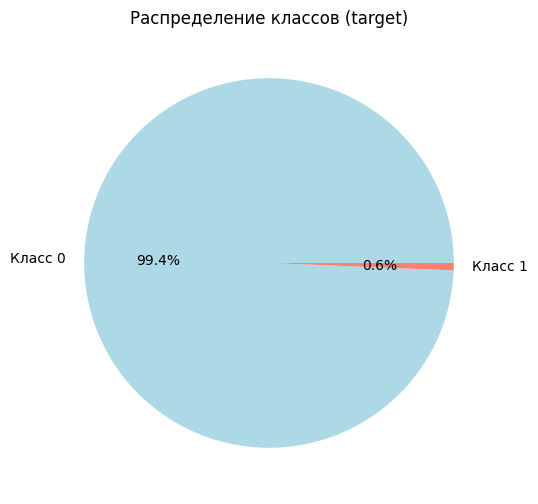

In [220]:
class_counts = df["target"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=["Класс 0", "Класс 1"], autopct="%1.1f%%", colors=["lightblue", "salmon"])
plt.title("Распределение классов (target)")
plt.show()

In [221]:
df = df.drop(['ym:s:parsedParamsKey2','ym:s:parsedParamsKey1', 'ym:s:parsedParamsKey3', 'ym:s:parsedParamsKey7', 
              'ym:s:parsedParamsKey5', 'ym:s:parsedParamsKey10', 'ym:s:parsedParamsKey8',
              'ym:s:parsedParamsKey6', 'ym:s:parsedParamsKey4', 'ym:s:parsedParamsKey9', 'ym:s:endURL',
              'ym:s:date', 'ym:s:goalsDateTime', 'ym:s:dateTimeUTC', 'ym:s:goalsID', 'ym:s:counterUserIDHash',
              'ym:s:visitID', 'ym:s:goalsSerialNumber', 'ym:s:offlineCallTag', 'ym:s:offlineCallTalkDuration',
              'ym:s:firstSearchEngineRoot', 'ym:s:cross_device_firstSearchEngineRoot', 'ym:s:physicalScreenHeight',
              'ym:s:windowClientWidth'], axis=1)

In [222]:
X = df.drop(columns=["target"])
y = df["target"]

cat_features = X.select_dtypes(exclude=["number"]).columns.tolist()

for col in cat_features:
    X[col] = X[col].fillna("unknown").astype(str)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, label=y_valid, cat_features=cat_features)

In [223]:
catboost = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function="Logloss", verbose=100)
catboost.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

y_pred = catboost.predict(X_valid)

0:	learn: 0.4754566	test: 0.4754788	best: 0.4754788 (0)	total: 47ms	remaining: 4.66s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01284188462
bestIteration = 32

Shrink model to first 33 iterations.


In [224]:
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, catboost.predict_proba(X_valid)[:, 1])

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

Accuracy: 0.9971
Precision: 0.8750
Recall: 0.6364
F1 Score: 0.7368
ROC AUC: 0.9885
Confusion Matrix:
[[3377    2]
 [   8   14]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3379
           1       0.88      0.64      0.74        22

    accuracy                           1.00      3401
   macro avg       0.94      0.82      0.87      3401
weighted avg       1.00      1.00      1.00      3401



In [225]:
feature_importances = catboost.get_feature_importance(train_pool)
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

In [226]:
feature_importance_df[feature_importance_df['Importance'] > 1]

,Feature,Importance
32,ym:s:visitDuration,23.493367
30,ym:s:regionCountryID,9.137179
331,ym:s:windowClientHeight,6.923961
14,ym:s:goalsCurrency,6.377538
353,ym:s:offlineCallMissed,5.496644
354,ym:s:offlineCallURL,5.387575
316,ym:s:physicalScreenWidth,4.819555
26,ym:s:pageViews,4.165093
28,ym:s:regionCityID,3.924290
68,ym:s:lastSearchEngine,3.407930


In [227]:
feature_importance_df[feature_importance_df['Importance'] > 1]['Feature'].to_list()

['ym:s:visitDuration',
 'ym:s:regionCountryID',
 'ym:s:windowClientHeight',
 'ym:s:goalsCurrency',
 'ym:s:offlineCallMissed',
 'ym:s:offlineCallURL',
 'ym:s:physicalScreenWidth',
 'ym:s:pageViews',
 'ym:s:regionCityID',
 'ym:s:lastSearchEngine',
 'ym:s:offlineCallHoldDuration',
 'ym:s:offlineCallFirstTimeCaller',
 'ym:s:last_yandex_direct_clickUTMMedium',
 'ym:s:browserMajorVersion',
 'ym:s:clientTimeZone',
 'ym:s:automaticSearchEngineRoot',
 'ym:s:last_yandex_direct_clickSearchEngineRoot',
 'ym:s:last_yandex_direct_clickUTMSource']

In [228]:
col = ['ym:s:visitDuration', 'ym:s:regionCountryID', 'ym:s:windowClientHeight',
       'ym:s:goalsCurrency', 'ym:s:offlineCallMissed',
       'ym:s:physicalScreenWidth', 'ym:s:pageViews', 'ym:s:regionCityID',
       'ym:s:lastSearchEngine', 'ym:s:clientTimeZone', 'target']

df_filter = df[col]
df_filter

,ym:s:visitDuration,ym:s:regionCountryID,ym:s:windowClientHeight,ym:s:goalsCurrency,ym:s:offlineCallMissed,ym:s:physicalScreenWidth,ym:s:pageViews,ym:s:regionCityID,ym:s:lastSearchEngine,ym:s:clientTimeZone,target
0,15,225,663,[\'\'],[],1170,1,0,google_search,180,0
1,15,225,729,[\'\'],[],900,1,0,NaN,180,0
2,82,225,720,[\'\'],[],1080,2,10,google_search,180,0
3,0,225,929,[\'\'],[],1920,1,2,google_search,180,0
4,372,159,827,[\'\'],[],407,5,10306,NaN,300,0
...,...,...,...,...,...,...,...,...,...,...,...
13599,15,225,832,[\'\'],[],1470,1,45,google_search,180,0
13600,0,96,733,[\'\'],[],1080,1,100,google_search,120,0
13601,15,225,657,[\'\'],[],1080,1,49,google_search,180,0
13602,676,225,745,[\'\'],[0],1080,5,0,yandex_mobile,180,0


## ym:s:visitDuration

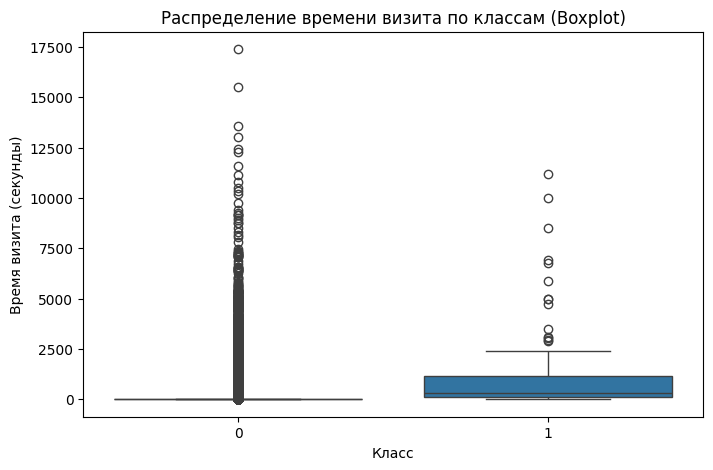

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='ym:s:visitDuration', data=df_filter)
plt.title('Распределение времени визита по классам (Boxplot)')
plt.xlabel('Класс')
plt.ylabel('Время визита (секунды)')
plt.show()

In [230]:
df_filter.groupby('target')['ym:s:visitDuration'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,13517.0,204.157209,859.322128,0.0,14.0,15.0,20.0,17387.0
1,87.0,1299.551724,2252.475712,29.0,134.5,313.0,1161.0,11179.0


In [231]:
df_filter.groupby('target')['ym:s:visitDuration'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).unstack()

,0.10,0.25,0.50,0.75,0.90
target,,,,,
0,0.0,14.0,15.0,20.0,200.4
1,54.0,134.5,313.0,1161.0,3991.6


In [ ]:
bins = [0, 15, 200, 1161, 3991, df_filter['ym:s:visitDuration'].max()]
labels = ['Мгновенный выход', 'Короткий визит', 'Средний визит', 'Долгий визит', 'Очень долгий визит']

df_filter['visit_category'] = pd.cut(df_filter['ym:s:visitDuration'], bins=bins, labels=labels)
df_filter.groupby(['target', 'visit_category']).size().unstack()

/tmp/ipykernel_75365/3780531131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['visit_category'] = pd.cut(df_filter['ym:s:visitDuration'], bins=bins, labels=labels)
/tmp/ipykernel_75365/3780531131.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filter.groupby(['target', 'visit_category']).size().unstack()


visit_category,Мгновенный выход,Короткий визит,Средний визит,Долгий визит,Очень долгий визит
target,,,,,
0,6620,3401,732,425,195
1,0,28,37,13,9


In [233]:
le = LabelEncoder()
data["visit_category_encoded"] = le.fit_transform(df_filter["visit_category"])

## ym:s:regionCountryID

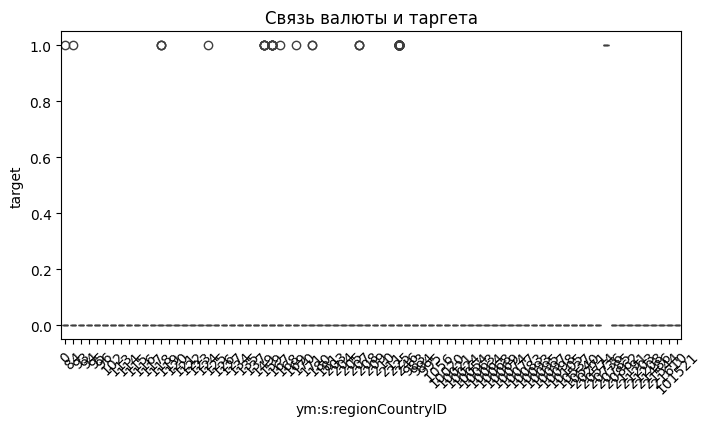

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x="ym:s:regionCountryID", y="target", data=df_filter)
plt.xticks(rotation=45)
plt.title("Связь валюты и таргета")
plt.show()

In [ ]:
df_filter.groupby('ym:s:regionCountryID')['target'].sum().sort_values(ascending=False).head(20)

ym:s:regionCountryID
225      59
159       8
149       6
207       3
118       3
171       2
20736     1
167       1
124       1
169       1
0         1
84        1
10074     0
10024     0
10063     0
10064     0
10021     0
10068     0
10020     0
10069     0
Name: target, dtype: int64

In [236]:
country_counts = df_filter.groupby('ym:s:regionCountryID')['target'].sum().sort_values(ascending=False)
data['country_freq'] = df_filter['ym:s:regionCountryID'].map(country_counts)

## ym:s:windowClientHeight

In [237]:
df_filter.groupby('ym:s:windowClientHeight')['target'].sum().sort_values(ascending=False)

ym:s:windowClientHeight
729     4
669     3
663     3
665     2
1015    2
       ..
646     0
647     0
649     0
650     0
2160    0
Name: target, Length: 758, dtype: int64

In [238]:
window_counts = df_filter.groupby('ym:s:windowClientHeight')['target'].sum().sort_values(ascending=False)
df_filter['window_freq'] = df_filter['ym:s:windowClientHeight'].map(window_counts).fillna(0)
data['window_freq'] = df_filter['window_freq'].replace(0, 0)

/tmp/ipykernel_75365/1259537708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['window_freq'] = df_filter['ym:s:windowClientHeight'].map(window_counts).fillna(0)


## ym:s:goalsCurrency

In [239]:
df_filter['ym:s:goalsCurrency'].unique()

array(["[\\'\\']",
       "[\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\']", "[\\'\\',\\'\\',\\'\\',\\'\\']",
       "[\\'Russian Ruble\\']",
       "[\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'\\',\\'\\',\\'\\',\\'Russian Ruble\\',\\'Russian Ruble\\']",
       "[\\'Euro\\']",
       "[\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\',\\'\\

In [240]:
common_currencies = ['Russian Ruble', 'Euro', 'Kazakh Tenge', 'Som', 'Uzbekistan Sum']

In [241]:
def create_currency_feature(currency_list, currencies):
    counts = {currency: currency_list.count(currency) for currency in currencies}
    feature_parts = [f"{count}_{currency[0].lower()}" for currency, count in counts.items() if count > 0]
    return "_".join(feature_parts) if feature_parts else "Other"

df_filter['currency_feature'] = df_filter['ym:s:goalsCurrency'].apply(lambda x: create_currency_feature(x, common_currencies))
print(df_filter['currency_feature'].value_counts())

currency_feature
Other          13275
2_r              239
1_r               58
3_r               15
1_e                4
4_r                4
1_k                3
2_r_1_k            1
5_r                1
1_u                1
1_k_1_s            1
2_e                1
1_r_1_s_2_u        1
Name: count, dtype: int64


/tmp/ipykernel_75365/540137821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['currency_feature'] = df_filter['ym:s:goalsCurrency'].apply(lambda x: create_currency_feature(x, common_currencies))


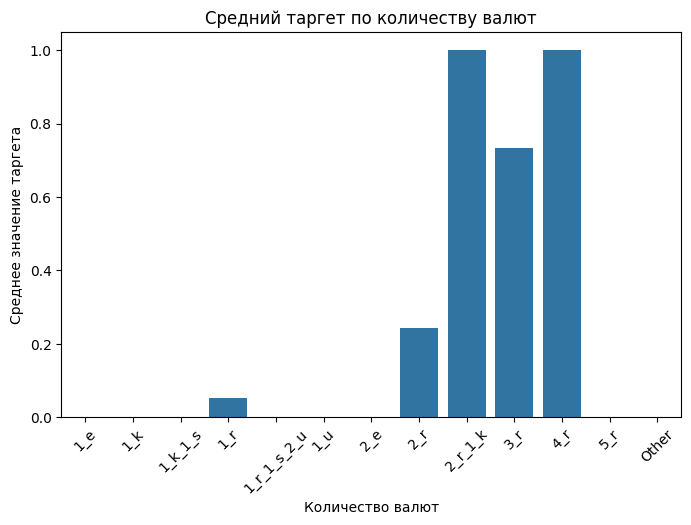

In [242]:
df_analysis = df_filter.groupby('currency_feature')['target'].agg(['count', 'mean', 'median'])

plt.figure(figsize=(8, 5))
sns.barplot(x=df_analysis.index, y=df_analysis["mean"])
plt.xticks(rotation=45)
plt.title("Средний таргет по количеству валют")
plt.xlabel("Количество валют")
plt.ylabel("Среднее значение таргета")
plt.show()

In [243]:
df_filter["rub_present"] = df_filter["currency_feature"].str.contains("_r").astype(int)

/tmp/ipykernel_75365/2449327728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter["rub_present"] = df_filter["currency_feature"].str.contains("_r").astype(int)


In [244]:
from scipy.stats import kruskal

groups = [df_filter[df_filter["currency_feature"] == cat]["target"] for cat in df_analysis.index]
stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis p-value: {p_value}")

Kruskal-Wallis p-value: 0.0


In [245]:
country_counts = df.groupby('ym:s:regionCountryID')['target'].sum().sort_values(ascending=False)

data['country_freq'] = df['ym:s:regionCountryID'].map(country_counts)

## ym:s:offlineCallMissed

In [246]:
df_filter.groupby('ym:s:offlineCallMissed')['target'].sum().sort_values(ascending=False)

ym:s:offlineCallMissed
[0,0,0,0,0,0]                                      19
[0,0,0,0,0,0,0]                                    10
[0,0,0,0,0,0,0,0,0]                                10
[0,0,0,0,0,0,0,0]                                  10
[0,0,0,0,0,0,0,0,0,0]                               9
[0,0,0,0,0]                                         7
[0,0,0,0]                                           6
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]                 3
[0,0,0,0,0,0,0,0,0,0,0,0,0]                         3
[0,0]                                               2
[0,0,0,0,0,0,0,0,0,0,0,0]                           2
[0,0,0,0,0,0,0,0,0,0,0]                             2
[0,0,0]                                             1
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]     1
[0,0,0,0,0,0,0,0,0,0,0,0,0,0]                       1
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]                   1
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]       0
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]             0
[0,0,

In [247]:
df_filter['ym:s:offlineCallMissed'] = df_filter['ym:s:offlineCallMissed'].apply(lambda x: ast.literal_eval(x))

data['ym:s:offlineCallMissed'] = df_filter['ym:s:offlineCallMissed'].apply(
    lambda x: 0 if x == [] or x == [0] else 1
)

/tmp/ipykernel_75365/758529902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['ym:s:offlineCallMissed'] = df_filter['ym:s:offlineCallMissed'].apply(lambda x: ast.literal_eval(x))


## ym:s:physicalScreenWidth

In [248]:
df_filter.groupby('ym:s:physicalScreenWidth')['target'].sum().sort_values(ascending=False)

ym:s:physicalScreenWidth
1080    18
1536    15
1920    12
1170    10
2560     3
        ..
1152     0
1174     0
1178     0
1182     0
9030     0
Name: target, Length: 265, dtype: int64

In [249]:
data['ym:s:physicalScreenWidth'] = df_filter['ym:s:physicalScreenWidth'].apply(lambda x: 1 if x > 0 else 0)

## ym:s:pageViews

In [250]:
df_filter.groupby('ym:s:pageViews')['target'].sum().sort_values(ascending=False)

ym:s:pageViews
1     21
2     16
3     11
4     10
5      6
6      6
12     4
8      4
11     2
9      2
10     1
13     1
14     1
32     1
17     1
22     0
41     0
29     0
25     0
24     0
15     0
21     0
20     0
19     0
18     0
16     0
7      0
74     0
Name: target, dtype: int64

In [251]:
data['ym:s:pageViews'] = df_filter['ym:s:pageViews'].apply(lambda x: 1 if 1 <= x <= 14 else 0)

## ym:s:regionCityID

In [252]:
df_filter.groupby('ym:s:regionCityID')['target'].sum().sort_values(ascending=False)

ym:s:regionCityID
213       25
0         11
162        4
163        3
2          3
          ..
10668      0
10670      0
10715      0
10716      0
218625     0
Name: target, Length: 630, dtype: int64

In [253]:
data['ym:s:regionCityID'] = df_filter['ym:s:regionCityID'].apply(lambda x: 1 if x > 0 else 0)

## ym:s:clientTimeZone

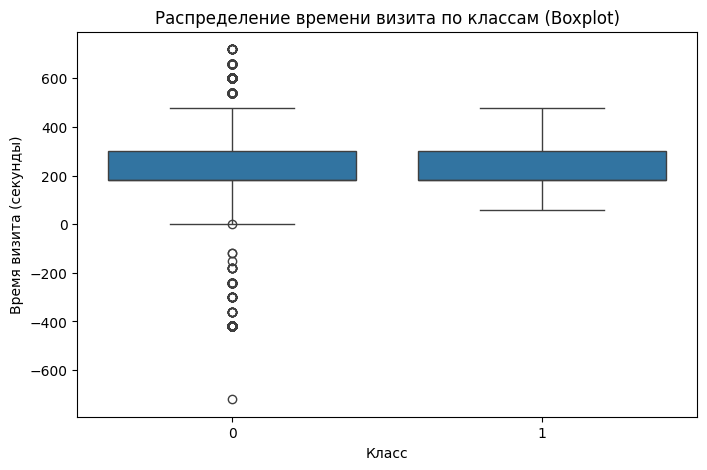

In [254]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='ym:s:clientTimeZone', data=df_filter)
plt.title('Распределение времени визита по классам (Boxplot)')
plt.xlabel('Класс')
plt.ylabel('Время визита (секунды)')
plt.show()

In [255]:
df_filter.groupby('target')['ym:s:clientTimeZone'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,13517.0,219.181697,132.294665,-720.0,180.0,180.0,300.0,720.0
1,87.0,226.206897,80.654898,60.0,180.0,180.0,300.0,480.0


In [256]:
df_filter['ym:s:clientTimeZone'].value_counts()

ym:s:clientTimeZone
 180    8238
 300    2486
 420     724
 240     451
 120     378
 360     332
-420     206
 480     180
 0       172
 600     167
 540      88
 660      51
 60       47
-240      33
-300      16
 720      13
-360       8
-180       6
-120       2
 330       2
-150       1
-720       1
 210       1
-1         1
Name: count, dtype: int64

In [257]:
def categorize_time_zone(value):
    if value <= -360:
        return 'UTC-12 to UTC-6'
    elif value <= 0:
        return 'UTC-6 to UTC+0'
    elif value <= 180:
        return 'UTC+0 to UTC+3'
    else:
        return 'UTC+3 to UTC+12'

df_filter['time_zone_category'] = df_filter['ym:s:clientTimeZone'].apply(categorize_time_zone)

/tmp/ipykernel_75365/1681609596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['time_zone_category'] = df_filter['ym:s:clientTimeZone'].apply(categorize_time_zone)


In [258]:
data["visit_category_encoded"] = le.fit_transform(df_filter["visit_category"])

In [259]:
data["target"] = df["target"]

In [260]:
data.isna().sum()

visit_category_encoded      0
country_freq                0
window_freq                 0
ym:s:offlineCallMissed      0
ym:s:physicalScreenWidth    0
ym:s:pageViews              0
ym:s:regionCityID           0
target                      0
dtype: int64

In [261]:
data

,visit_category_encoded,country_freq,window_freq,ym:s:offlineCallMissed,ym:s:physicalScreenWidth,ym:s:pageViews,ym:s:regionCityID,target
0,2,59,3,0,1,1,0,0
1,2,59,4,0,1,1,0,0
2,1,59,0,0,1,1,1,0
3,5,59,0,0,1,1,1,0
4,4,8,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
13599,2,59,0,0,1,1,1,0
13600,5,0,0,0,1,1,1,0
13601,2,59,1,0,1,1,1,0
13602,4,59,0,0,1,1,0,0


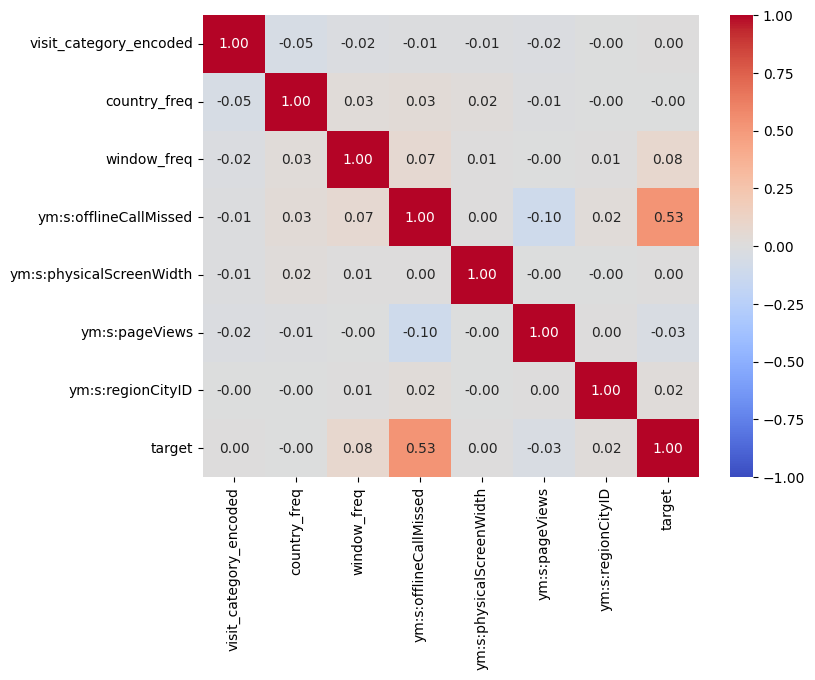

In [262]:
corr_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [263]:
features = data.drop(columns=["target"])  
target = data["target"]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

df_scaled = pd.DataFrame(df_scaled, columns=features.columns)

df_scaled["target"] = target

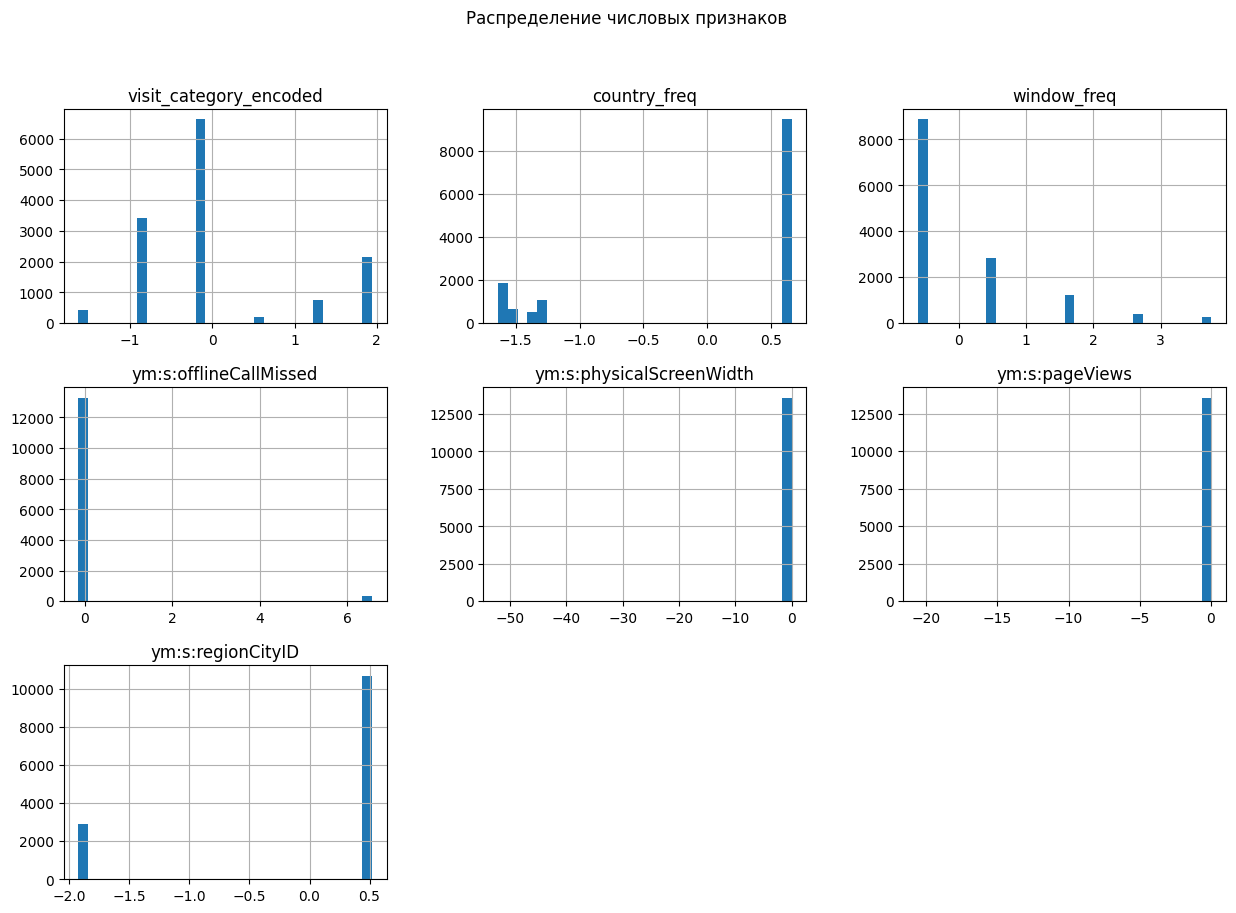

In [264]:
numerical_features = df_scaled.drop(columns=["target"])

numerical_features.hist(figsize=(15, 10), bins=30)
plt.suptitle("Распределение числовых признаков")
plt.show()

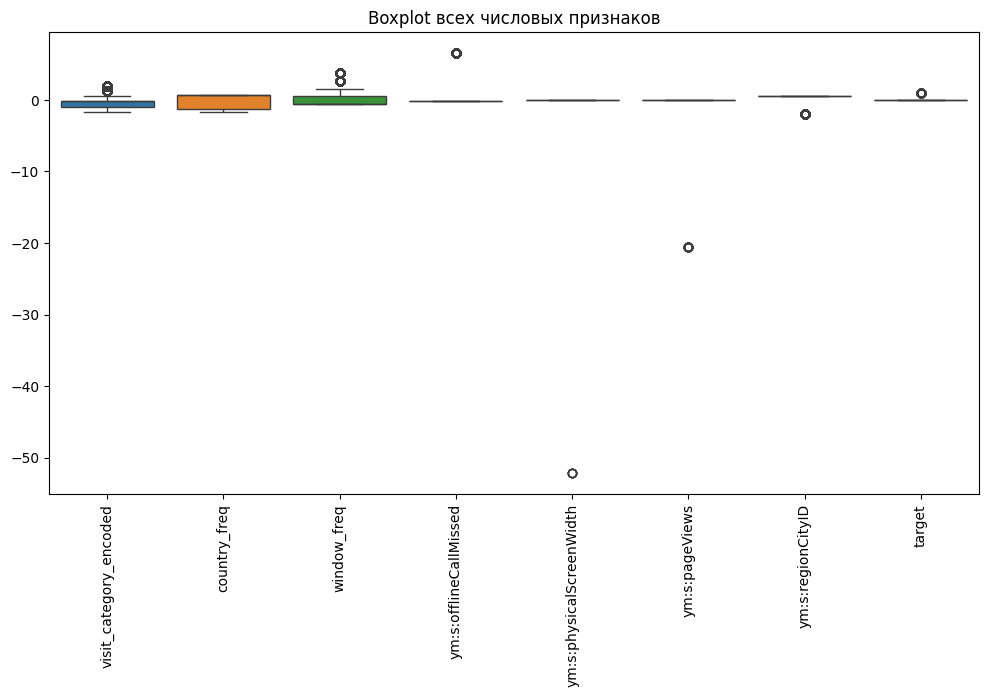

In [265]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.title("Boxplot всех числовых признаков")
plt.show()

In [266]:
X = df_scaled.drop(columns=["target"])
y = df_scaled["target"]

In [267]:
importances = mutual_info_classif(X, y)
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_importance

ym:s:offlineCallMissed      0.026275
visit_category_encoded      0.009035
window_freq                 0.007640
ym:s:regionCityID           0.002144
country_freq                0.001840
ym:s:physicalScreenWidth    0.000000
ym:s:pageViews              0.000000
dtype: float64

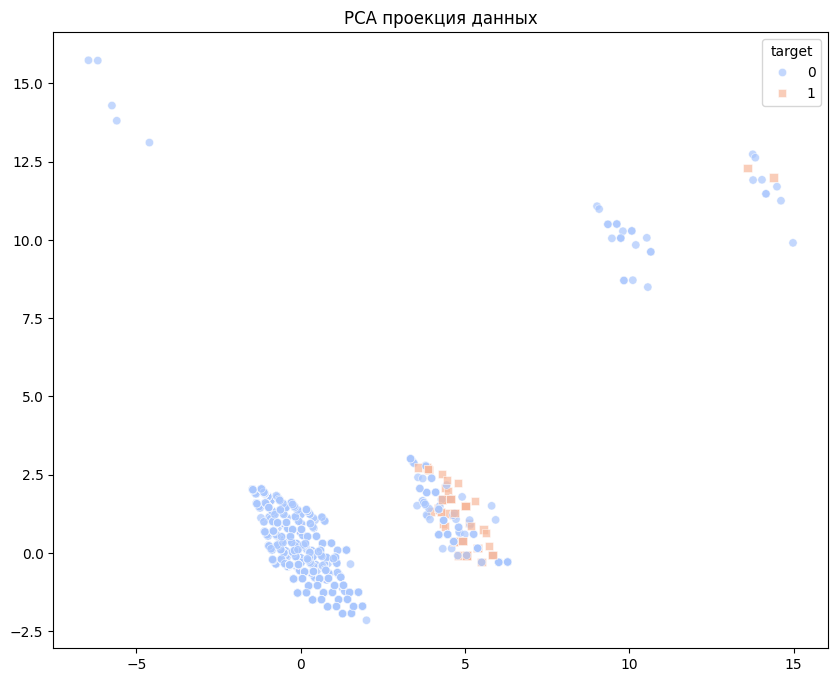

In [268]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y,
    style=y,
    palette="coolwarm",
    markers={0: "o", 1: "s"},
    alpha=0.7
)

plt.title("PCA проекция данных")
plt.show()

In [ ]:
X = df_scaled.drop('target', axis=1)
y = df_scaled['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

smote_train = SMOTE(random_state=42)
X_train_res, y_train_res = smote_train.fit_resample(X_train, y_train)
print(f'Классы в обучающих данных после оверсемплинга: {y_train_res.value_counts()}')

print(f'Классы в валидационных данных: {y_val.value_counts()}')
print(f'Классы в тестовых данных: {y_test.value_counts()}')

Классы в обучающих данных после оверсемплинга: target
0    8110
1    8110
Name: count, dtype: int64
Классы в валидационных данных: target
0    2703
1      18
Name: count, dtype: int64
Классы в тестовых данных: target
0    2704
1      17
Name: count, dtype: int64


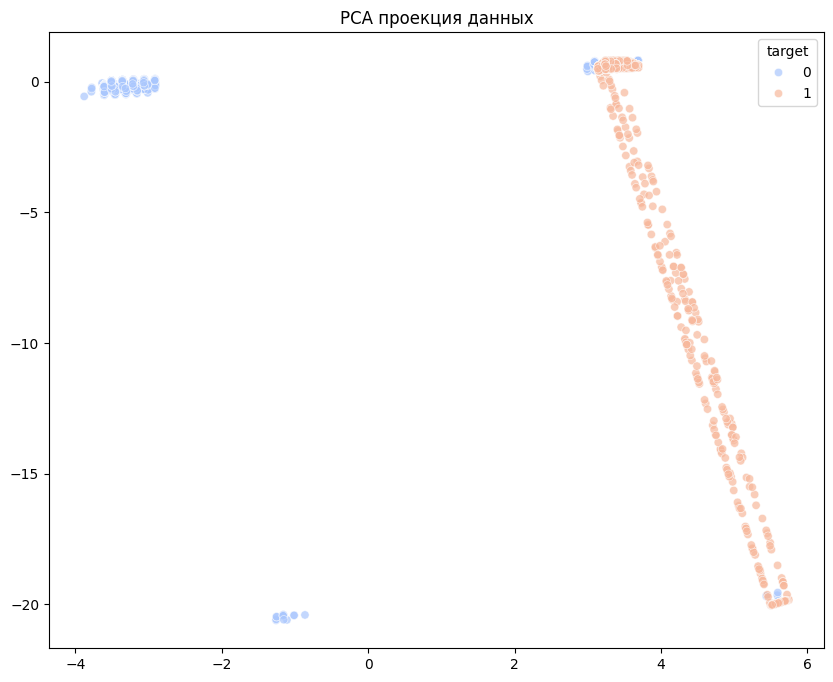

In [270]:
X = X_train_res
y = y_train_res

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("PCA проекция данных")
plt.show()

In [271]:
print(X_train_res.shape)
print(y_train_res.shape)

(16220, 7)
(16220,)


In [272]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):

    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    print("Validation classification report:")
    print(classification_report(y_val, y_val_pred))
    
    y_test_pred = model.predict(X_test)
    print("Test classification report:")
    print(classification_report(y_test, y_test_pred))
    
    plot_decision_boundaries(model, X_train, y_train, X_val, y_val, title="Validation Set")
    plot_decision_boundaries(model, X_train, y_train, X_test, y_test, title="Test Set")

def plot_decision_boundaries(model, X_train, y_train, X_set, y_set, title):

    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_set_pca = pca.transform(X_set)

    model.fit(X_train_pca, y_train)
    
    x_min, x_max = X_set_pca[:, 0].min() - 1, X_set_pca[:, 0].max() + 1
    y_min, y_max = X_set_pca[:, 1].min() - 1, X_set_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = plt.scatter(X_set_pca[:, 0], X_set_pca[:, 1], c=y_set, cmap='viridis', edgecolor='k', s=50)
    
    plt.title(f"Decision Boundaries ({title})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

Validation classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2703
           1       0.24      1.00      0.39        18

    accuracy                           0.98      2721
   macro avg       0.62      0.99      0.69      2721
weighted avg       0.99      0.98      0.99      2721

Test classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2704
           1       0.30      1.00      0.46        17

    accuracy                           0.99      2721
   macro avg       0.65      0.99      0.73      2721
weighted avg       1.00      0.99      0.99      2721



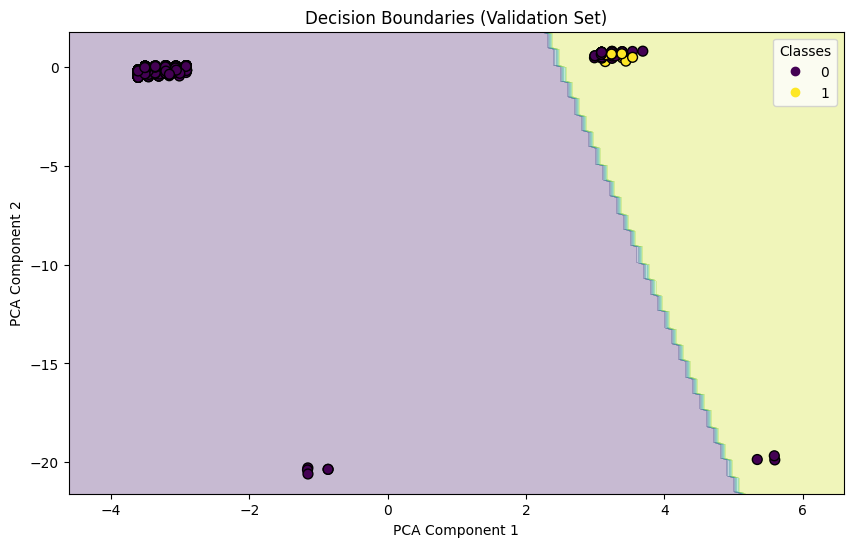

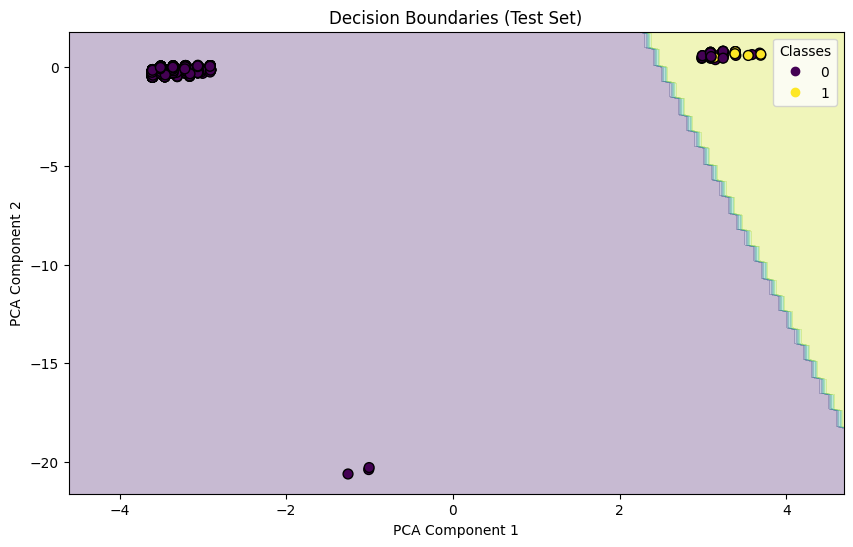

In [273]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(log_reg, X_train_res, y_train_res, X_val, y_val, X_test, y_test)

Validation classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2703
           1       0.39      0.89      0.54        18

    accuracy                           0.99      2721
   macro avg       0.69      0.94      0.77      2721
weighted avg       1.00      0.99      0.99      2721

Test classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2704
           1       0.40      1.00      0.58        17

    accuracy                           0.99      2721
   macro avg       0.70      1.00      0.79      2721
weighted avg       1.00      0.99      0.99      2721



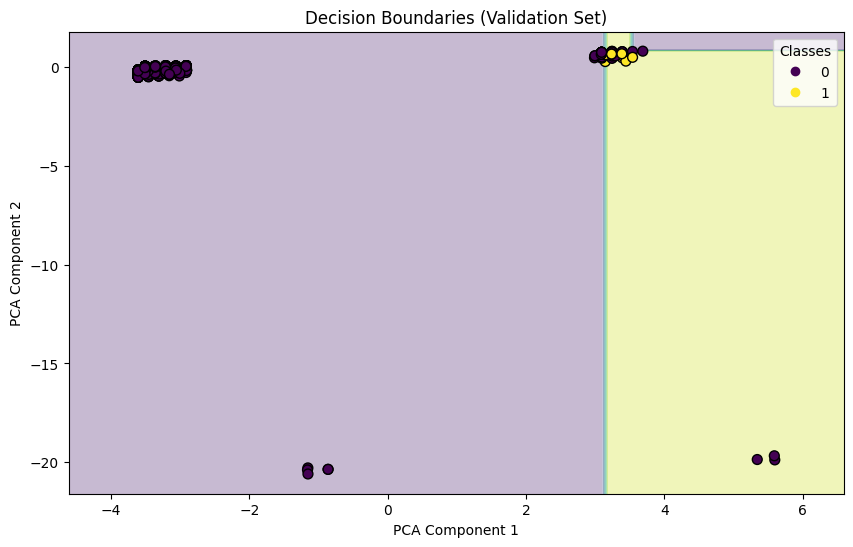

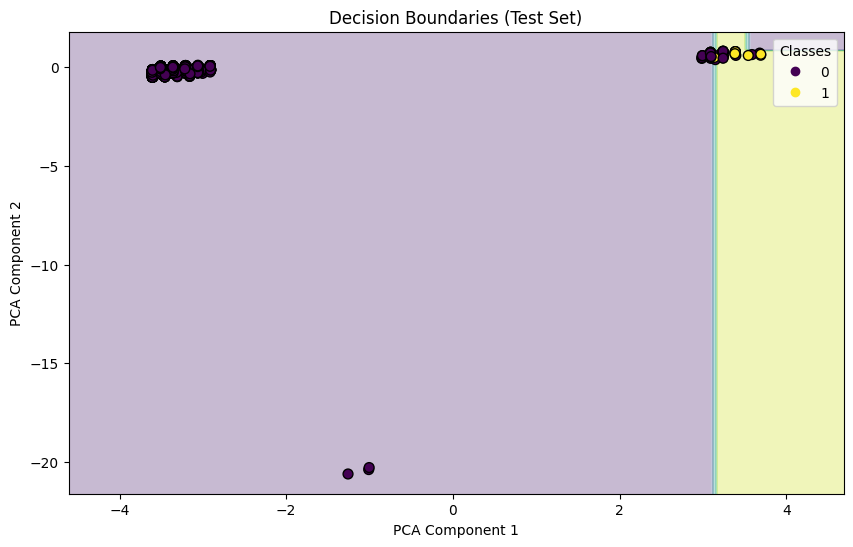

In [274]:
rf_clf = RandomForestClassifier(
    n_estimators=50,  
    max_depth=5,  
    min_samples_split=5,  
    min_samples_leaf=3,  
    random_state=42
)
evaluate_model(rf_clf, X_train_res, y_train_res, X_val, y_val, X_test, y_test)

Validation classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2703
           1       0.41      1.00      0.58        18

    accuracy                           0.99      2721
   macro avg       0.70      1.00      0.79      2721
weighted avg       1.00      0.99      0.99      2721

Test classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2704
           1       0.41      1.00      0.59        17

    accuracy                           0.99      2721
   macro avg       0.71      1.00      0.79      2721
weighted avg       1.00      0.99      0.99      2721



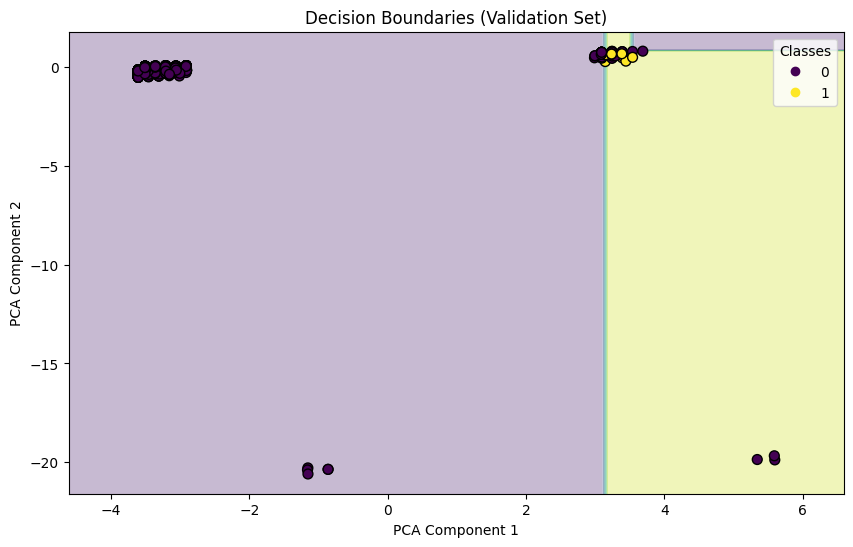

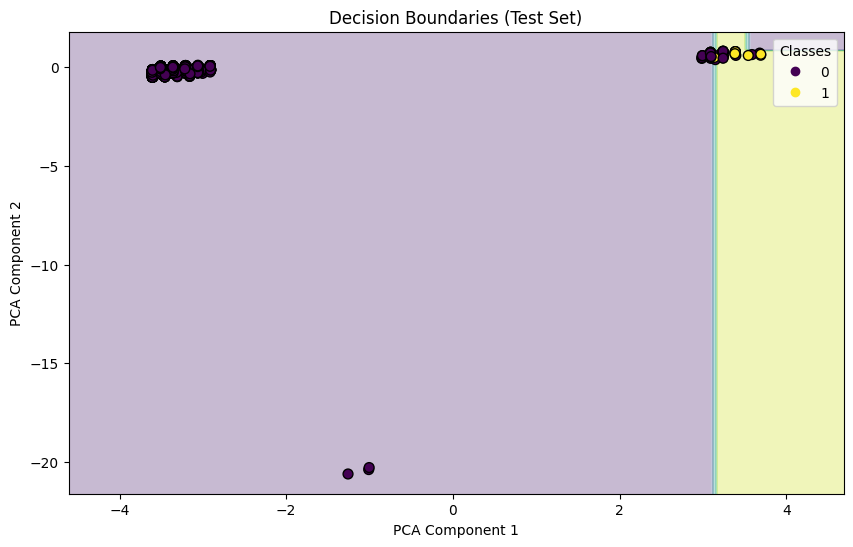

In [275]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
meta_model = LogisticRegression(C=0.1)

stacking_model = StackingClassifier(estimators=[('rf', rf), ('xgb', xgb_model)], final_estimator=meta_model)
evaluate_model(stacking_model, X_train_res, y_train_res, X_val, y_val, X_test, y_test)